# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 2 - Classification with MLP



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit.

**Names of person you have worked with goes here:** 

**Submitters:**
Group 12
- Mark Carlebach
- Saurabh Kulkarni

###  Use only the libraries below:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
import seaborn as sns
from itertools import chain

from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import Callback, ModelCheckpoint, History, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras import optimizers
from keras.layers import Dropout

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

%matplotlib inline

Using TensorFlow backend.


<div class="theme"> Overview </div> 

### Galaxy Zoo
For this homework you will work with real astronomical data with the purpose of classifying galaxies based on visual attributes as they appear in astronomical surveys of the night sky, such as color and morphology. Galaxy morphology is strongly correlated with many physical parameters of those astronomical bodies, including their mass, density distribution, temperature, and star formation history. In turn, these parameters can be estimated using observations of the attributes mentioned above. 

The Galaxy Zoo project includes collected morphological attributes of nearly 900,000 galaxies drawn from the [Sloan Digital Sky Survey](http://skyserver.sdss.org/dr15/en/home.aspx). The annotation was provided by hundreds of thousands of volunteers, or 'citizen scientists' as we call them, who voted on the galaxy type based only on its image (for more details on galaxy morphology and classification see <a href="https://academic.oup.com/mnras/article/410/1/166/1032478">Chris Lintott et al.</a>). 

Your task is to train a binary classifier on the Galaxy Zoo data in order to distinguish an elliptical galaxy from spirals, mergers and unknown, which we will call non-elliptical galaxies, based on its visual morphology.  

We provide a subset of data in `galaxy_morphology_labeled.csv` so there is no need for you to download it. The full dataset is available at http://data.galaxyzoo.org.


<span class='sub-q'> Dataset Attributes:</span>
- **green_color**: the amount of light measured in the green frequency band (wavelength range 464 $\pm$ 128~nm)
- **red_color**: the amount of light measured in the red frequency band (wavelength range 658 $\pm$ 138~nm)
- **infrared_color**: the amount of light measured in the infrared frequency band (wavelength range 806 $\pm$ 149~nm)
- **de_vaucouleurs_fit_axial_ratio**: axial ratio associated with the [de Vaucouleurs fit](https://en.wikipedia.org/wiki/De_Vaucouleurs%27_law) to the two-dimensional image of the galaxy
- **exponential_fit_axial_ratio**: the axial ratio associated with an exponential fit to the two-D image of the galaxy 
- **exponential_disc_fit_log_likelihood**: log likelihood associated with an exponential fit to the two-D image of the galaxy
- **de_vaucouleurs_fit_log_likelihood**: log likelihood associated with a de Vaucouleurs fit to the two-D image of the galaxy
- **star_log_likelihood**: the log likelihood that the object is a point-like source (star) object rather than a galaxy
- **number_of_votes**: total number of volunteer votes
- **probability_elliptical**: fraction of votes for elliptical morphology
- **probability_spiral**: fraction of votes for spiral morphology
- **probability_unknown**: fraction of votes for unknown morphology
- **probability_merger**: fraction of votes for merger morphology
- **class**: morphology with the highest fraction of votes

Notice that the volunteers did not have access to any of the attributes but the galaxy shape when voting.

<div class='exercise'><b> Question 1: Models for Galaxy Classification [30pts] </b></div>

<span class='sub-q'> **1.1** Understanding the Problem.</span> It is a good practice to start by familiarizing yourself with the problem in hand. Read the atricle by [Manda Banerji et al.](https://academic.oup.com/mnras/article/406/1/342/1073212) and familiarize yourself with the attributes in the dataset and their descriptions. Based on your reading, which attributes in the data are most predictive of whether or not a galaxy is elliptical?


<span class='sub-q'> 1.2 Performing Data Exploration and Cleaning.</span> 



- **1.2.1** The color bands sometimes include values that are far away from the rest, what we call outliers. Outlier values might indicate bad measurements for example instrumental failures. Remove the data points with these values in the color band of your choice. 
- **1.2.2** Are the features sufficiently distinguishing for the classification task? Do elliptical galaxies differ enough in terms of these attributes from other types of objects in the sky? 

**Hint:** compare the distributions of features for elliptical galaxies with the feature distributions of other objects in the data set.

<span class='sub-q'> 1.3 Feature Engineering. </span> The practice of creating new features by combining observed features in the data using domain knowledge is called *feature engineering*. Astronomers often use differences in color bands as an engineered feature that serves as a proxy to temperature. Create two new features in the data that represent temperature. Do these two new features help distinguish elliptical galaxies from other objects, i.e., are these two new features useful for the classification task?

<span class='sub-q'> 1.4 Training a Baseline Classifier. </span> Using `keras`, construct and train a MLP classifier to classify galaxies as either elliptical or non-elliptical based on your expanded set of features. 

For the network you want to consider:
- the number of hidden layers
- the number of nodes in each hidden layer
- the activation function (we suggest starting with `relu`)
- the choice of a loss function
- the choice of mini-batch size (we suggest between 1000 and 5000)
- the choice of an optimizer and its parameters, for example: `learning rate`, `momentum`, and `learning rate decay`
- the number of epochs

**Hint:** You can expect to achieve an average classification accuracy of >80% with the appropriate choices.

<span class='sub-q'>1.5 Evaluating and Improving Your Classifier. </span> Choose an appropriate metric for evaluating your classifier. Is the average classification accuracy a good metric for this data given the distribution of the classes? Improve your classifier based on the distribution of the classes and on your evaluation of the baseline classifier. 

**Hint:** You can expect to achieve an average classification accuracy of >90% with this.

In [3]:
galaxy_df = pd.read_csv('data/galaxy_morphology_labeled.csv')
galaxy_df.head()

,green_color,red_color,infrared_color,de_vaucouleurs_fit_axial_ratio,exponential_fit_axial_ratio,exponential_disc_fit_log_likelihood,de_vaucouleurs_fit_log_likelihood,star_log_likelihood,number_of_votes,probability_elliptical,probability_spiral,probability_unknown,probability_merger,class
0,17.952690,17.077210,16.696932,0.652044,0.674899,-299.83917,-147.78073,-2480.1614,30,0.033,0.933,0.033,0.000,spiral
1,15.870294,15.128039,14.746254,0.661844,0.631145,-4980.44200,-2094.24630,-41855.1640,58,0.000,1.000,0.000,0.000,spiral
2,16.473410,15.633129,15.174894,0.324888,0.356353,-3732.98900,-946.47595,-26244.6110,43,0.186,0.744,0.070,0.000,spiral
3,17.137112,16.744455,16.542747,0.582045,0.656639,-33.33683,-587.22380,-4487.7620,63,0.143,0.810,0.048,0.000,spiral
4,17.995703,17.621641,17.377476,0.449918,0.462352,-26.84463,-130.57242,-2392.1540,42,0.167,0.738,0.071,0.024,spiral


### Your solutions 

## Q1.1 Understanding the problem

**Answer:**

The paper presents three different machine learning models, using the following set of parameters:
    
    i. colors and profile-fitting parameters (given in our data set for this assignment)
    ii. concentration, adaptive shape parameters and texture and
    iii. a combined model of all the above parameters.
    
to predict the three different types of galaxies - early types or elliptical, spirals and point sources/artefacts.

**Key observations:** 

*Model i.:* The article states that the early types (i.e., ellipticals and lenticular systems) are usually redder than spirals.  Point sources and artefacts, unfortunately, exhibit a wider range of colors that presumably includes red. The axial ratio for early types are larger than for spirals.  Combining these traditional color and profile-fitting parameters leads to *87% correct classification of early types.*

*Model ii.:* For these set of parameters, the model is able to distinguish well between spirals and early types. But the parameters are verys similar for point sources/artefacts and early types - leading to an accuracy of only 32% for the point sources/artefacts.

*Model iii.:* This model performs better than earlier two for all three types of galaxies - with accuracy being 92% for both early types and spirals and 96% for point sources/artefacts. 

**Conclusion:**
Ideally, we should try to model using all 12 parameters listed in the paper in table 1 and 2 to get the best accuracy. If not, the second best option would be to model with colors and profile-fitting parameters.

## Q1.2 Performing Data Exploration and Cleaning

In [4]:
galaxy_df.describe()

,green_color,red_color,infrared_color,de_vaucouleurs_fit_axial_ratio,exponential_fit_axial_ratio,exponential_disc_fit_log_likelihood,de_vaucouleurs_fit_log_likelihood,star_log_likelihood,number_of_votes,probability_elliptical,probability_spiral,probability_unknown,probability_merger
count,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000
mean,17.070687,16.440295,16.130761,0.608844,0.609354,-3868.090280,-2025.123462,-22239.118941,38.765791,0.365983,0.497452,0.093647,0.042877
std,1.165214,1.249285,1.319114,0.228268,0.221225,9036.116288,5628.712115,30610.822090,13.842021,0.303422,0.341853,0.167825,0.116282
min,7.238786,7.619027,7.231207,0.050000,0.050000,-155600.520000,-165467.890000,-244262.300000,7.000000,0.000000,0.000000,0.000000,0.000000
25%,16.550340,15.859993,15.510974,0.435455,0.437437,-3545.562500,-1676.673825,-25458.852750,28.000000,0.091000,0.143000,0.000000,0.000000
50%,17.319927,16.623186,16.270693,0.634461,0.630144,-730.916850,-676.399390,-11928.960000,34.000000,0.291000,0.561000,0.034000,0.000000
75%,17.833663,17.214431,16.903603,0.796282,0.788374,-133.104103,-284.920380,-5387.488300,51.000000,0.611000,0.812000,0.097000,0.032000
max,20.116318,27.952972,28.606903,0.999995,0.999997,0.000000,0.000000,0.000000,86.000000,1.000000,1.000000,1.000000,0.958000


In [5]:
def preprocess(fit_df, trans_df, non_binary: list):
    # scale
    df_scaled = trans_df.copy()
    scaler = StandardScaler().fit(fit_df[non_binary])
    df_scaled[non_binary] = pd.DataFrame(scaler.transform(df_scaled[non_binary]), index=df_scaled.index, columns=non_binary)
    
    # encode categorical variables
    df_dummies = pd.get_dummies(df_scaled, columns=['class'])
    exc_cols = ['class_merger', 'class_spiral', 'class_unknown', 'number_of_votes', 'probability_elliptical', 
                'probability_spiral', 'probability_unknown', 'probability_merger']
    inc_cols = set(df_dummies)^set(exc_cols)
    df_scaled = df_dummies[list(inc_cols)]
    
    # 1.3 feature engineering
    df_scaled['g-r'] = df_scaled['green_color']-df_scaled['red_color']
    df_scaled['r-i'] = df_scaled['red_color']-df_scaled['infrared_color']
    
    X = df_scaled[list(set(df_scaled.columns)^set(['class_elliptical']))]
    y = df_scaled['class_elliptical']
    
    return(df_scaled, X, y)

In [6]:
galaxy_train, galaxy_test = train_test_split(galaxy_df, test_size=0.3, random_state=42, 
                                                    stratify=galaxy_df['class'])

In [7]:
non_binary = list(set(galaxy_df.columns)^set(['class']))
galaxy_train_sc, X_train, y_train = preprocess(fit_df=galaxy_train, trans_df=galaxy_train, non_binary=non_binary)
galaxy_test_sc, X_test, y_test = preprocess(fit_df=galaxy_train, trans_df=galaxy_test, non_binary=non_binary)
display(X_train.shape)
display(y_train.shape)
display(galaxy_train_sc.shape)

/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

(14119, 10)

(14119,)

(14119, 11)

**Answer:**

- `preprocess()`: Function to scale all the numerical columns and do the required preprocessing on the data set. Note that we are fitting our `StandardScaler()` only on `galaxy_train`.
- Note that we exclude all the variables associated with voting and their proportions, viz. `number_of_votes`, `probability_elliptical`, `probability_spiral`, `probability_unknown` and `probability_merger` as they are used for calculating our target variable. 
- We also take out all the dummy variables associated with other classes and intend to build a network with a binary output - elliptical and non-elliptical.

### 1.2.1 Outliers

/usr/share/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


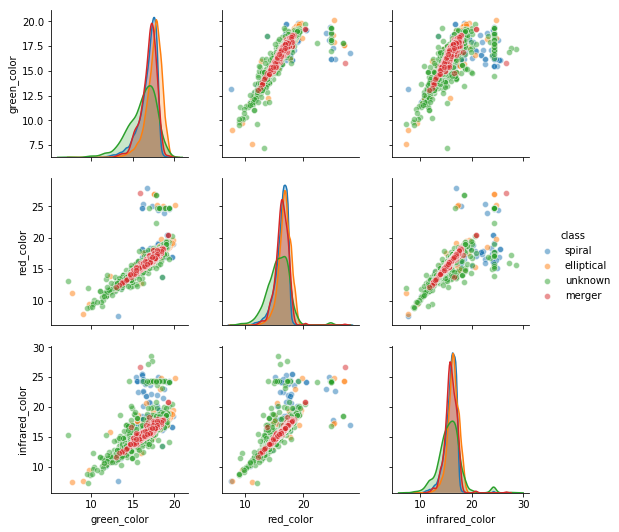

In [8]:
sns.pairplot(galaxy_df[['green_color', 'red_color', 'infrared_color','class']], 
             hue='class', plot_kws={'alpha': 0.5})

In [9]:
X_train = X_train[galaxy_train['red_color']<=21]
y_train = y_train[galaxy_train['red_color']<=21]
galaxy_train_sc = galaxy_train_sc[galaxy_train['red_color']<=21]
display(X_train.shape)
display(y_train.shape)
display(galaxy_train_sc.shape)

(14099, 10)

(14099,)

(14099, 11)

**Answer:**

Taking out the outliers by plotting all the colors against each other:

- Red and green colors seem to have a linear relationship with each other, whereas the `infrared_color` seems to have a curve at approx. $>22$.
- Looking at the scatterplot between `red_color` and `green_color` there seems to be a cluster of `red_color` $>21$ that don't follow the linear relationship between the two variables, hence filter out those points.
- Same thing seems to be happening in the plot between `infrared_color` and `green_color`, however, we see a curvilinear relationship at `infrared_color` $>=21$. So we dont remove these points.

### 1.2.2 Comparing Distributions

In [10]:
X_train.describe()

,de_vaucouleurs_fit_axial_ratio,exponential_disc_fit_log_likelihood,green_color,de_vaucouleurs_fit_log_likelihood,r-i,g-r,red_color,exponential_fit_axial_ratio,infrared_color,star_log_likelihood
count,14099.000000,14099.000000,14099.000000,14099.000000,14099.000000,14099.000000,14099.000000,14099.000000,14099.000000,14099.000000
mean,0.001323,-0.000598,-0.000815,-0.000511,-0.001952,0.008905,-0.009719,0.001429,-0.007767,-0.001023
std,0.999225,1.000618,0.999990,1.000651,0.335525,0.230596,0.966337,0.998918,0.976628,1.000375
min,-2.447931,-16.753021,-8.512123,-30.438938,-10.073813,-5.868791,-7.128488,-2.530519,-6.779937,-7.327352
25%,-0.757747,0.037006,-0.449331,0.061361,-0.029061,-0.128711,-0.467137,-0.776017,-0.472929,-0.105422
50%,0.117330,0.347050,0.213422,0.246400,0.039947,0.022231,0.142503,0.099323,0.102112,0.336947
75%,0.822664,0.411690,0.651764,0.318400,0.083072,0.160061,0.618566,0.810528,0.585479,0.548351
max,1.711762,0.426568,2.408523,0.371437,3.161889,3.761758,3.216901,1.764104,9.497033,0.725580


In [11]:
dist_cols = list(set(galaxy_train_sc.columns)^set(['g-r','r-i']))

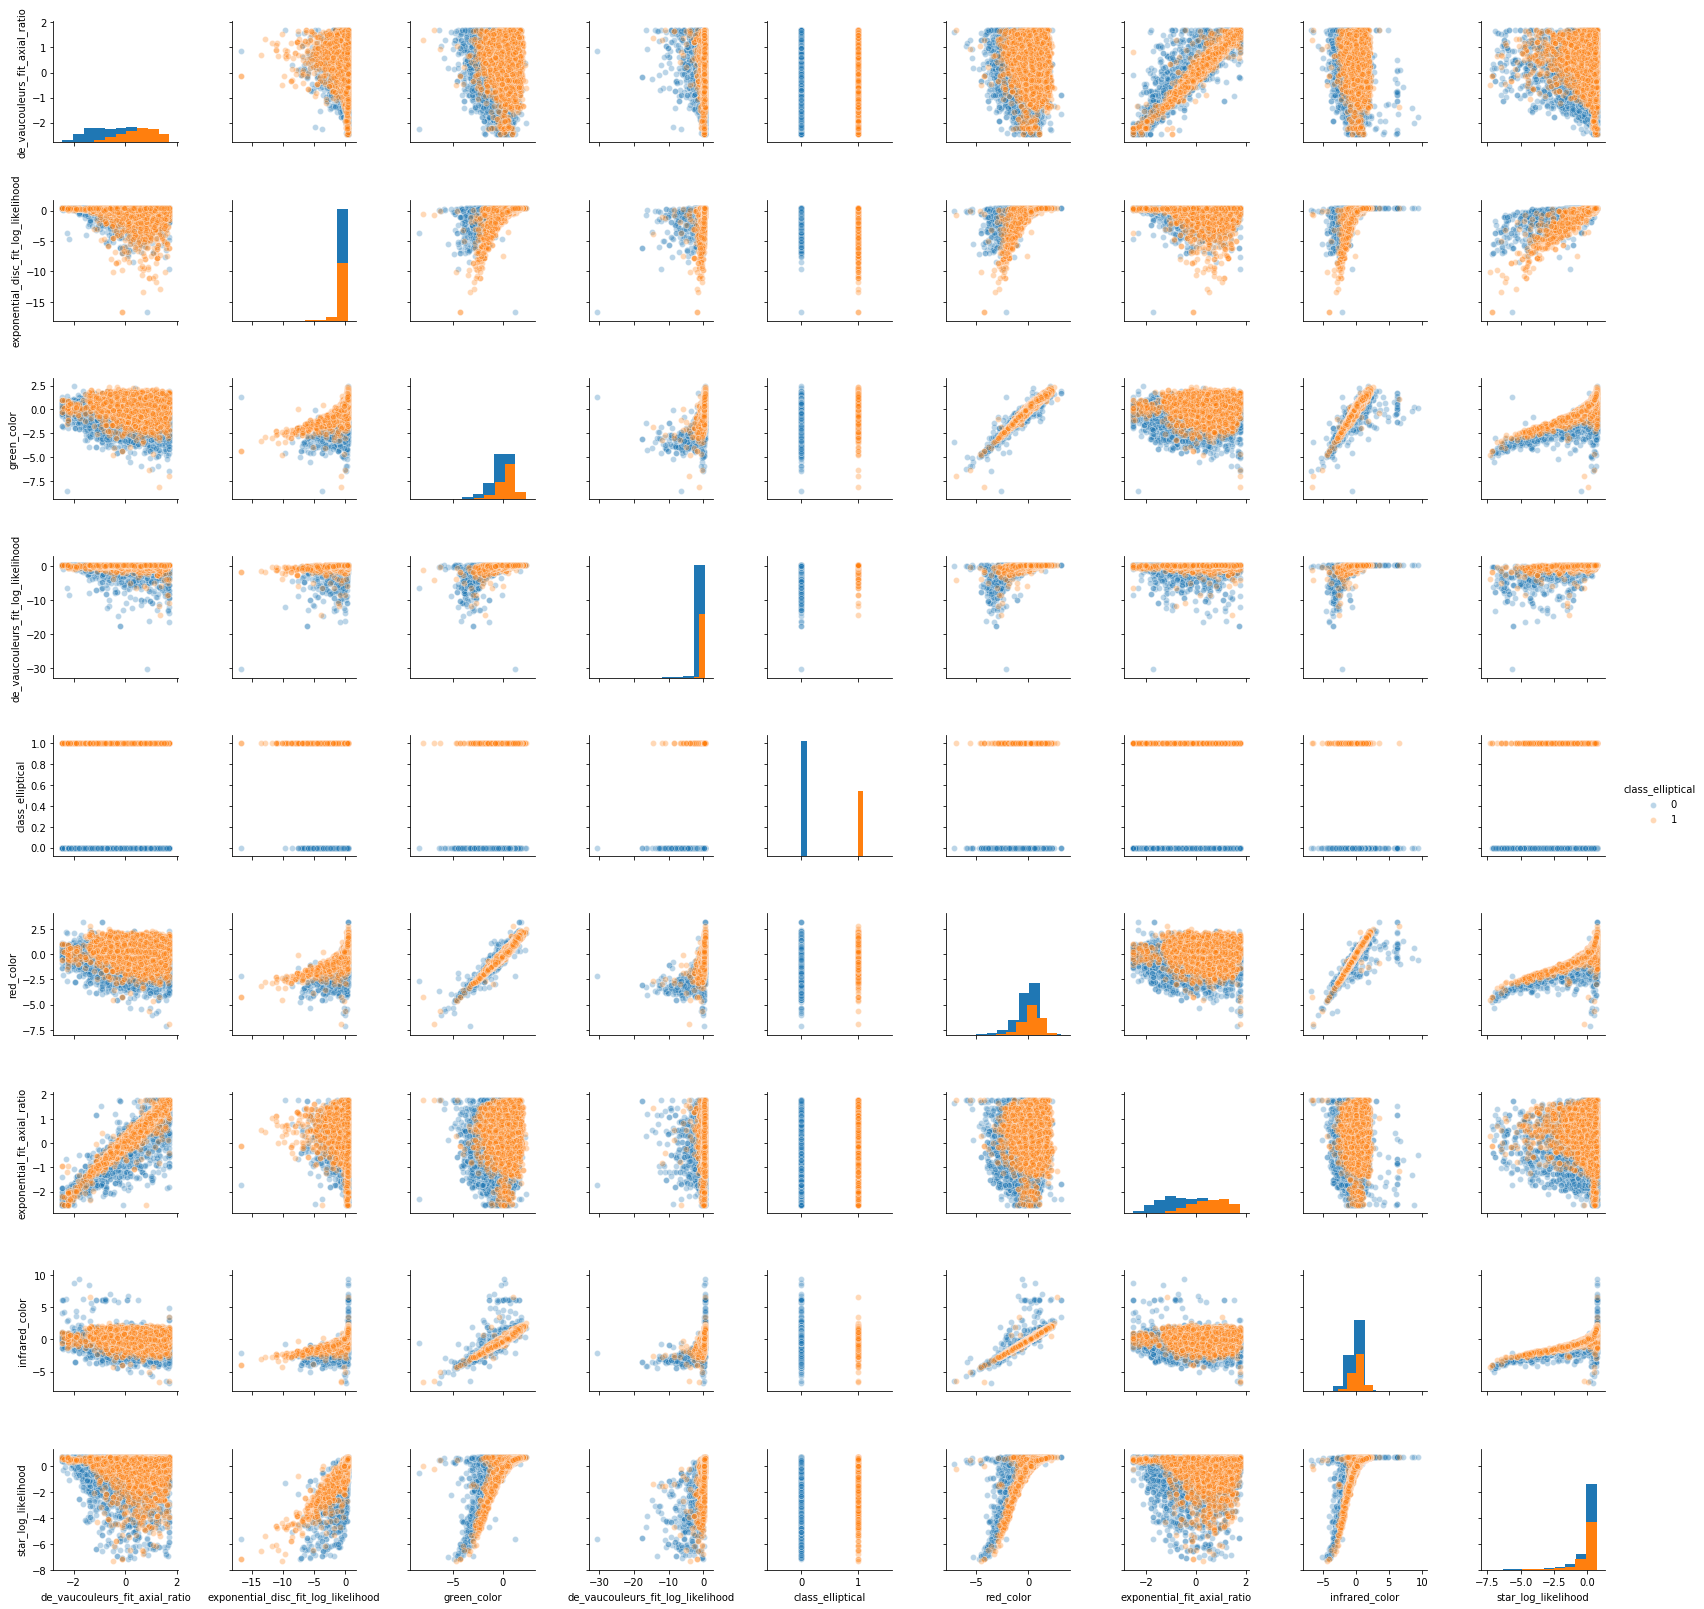

In [12]:
sns.pairplot(galaxy_train_sc[dist_cols], hue='class_elliptical', diag_kind='hist',
             plot_kws={'alpha': 0.3})

**Answer:**

Here we do a scatter plot matrix, which also gives us a `kde plot` for elliptical and non-elliptical galaxies, of all the variables being considered in the neural network to compare their distributions.

- `exponential_fit_axial_ratio` and `de_vaucouleurs_fit_axial_ratio` show the biggest difference in their distributions, with elliptical having higher ratios compared to the non-elliptical galaxies (synchronous with the conclusions from the paper in `Q.1`). The two are also highly correlated to each other. 
- In general, we also see a pattern where the features take values that are more concentrated for elliptical galaxies as compared to non-elliptical ones. For example, 
    - the colors show a very strong linear relationship with each other for elliptical galaxies compare to non-elliptical. 
    - the colors also show a strong curvilinear relationship with `star_log_likelihood` and `exponential_disc_fit_log_likelihood`.
    This is probably because we are grouping together all other types of galaxies that are not elliptical. 
    
These differences, although present, are not very obvious. So the features are fairly distinguishing for the two types of galaxies, but we might get better accuracy with exploring more features that could help the classification.

## Q1.3 Feature Engineering

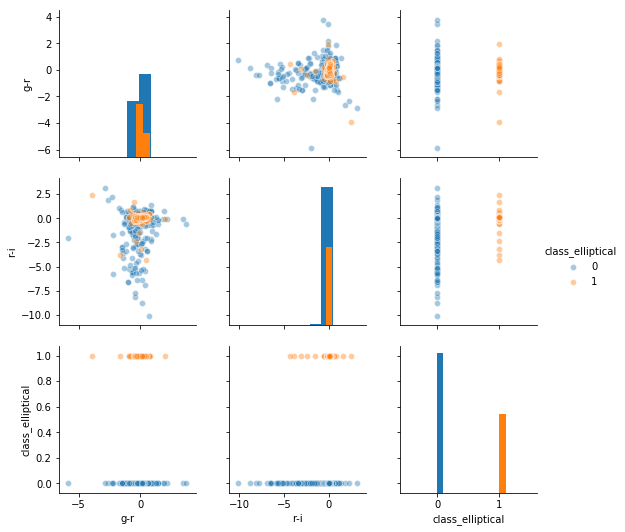

In [13]:
sns.pairplot(galaxy_train_sc[['g-r','r-i','class_elliptical']], hue='class_elliptical', 
             diag_kind='hist', plot_kws={'alpha': 0.4})

**Answer:**
- The values for elliptical galaxies, again, are more concentrated and higher for elliptical compared to non-elliptical galaxies.

## Q1.4 Training a Baseline Classifier

In [14]:
def build_nn(H, L, input_dim, out_act, loss, lr, momentum, decay, optimizer='sgd'):
    model = Sequential() 

    # hidden layers (L)
    for i in range(L):
        model.add(Dense(H, input_dim=input_dim, #kernel_initializer='uniform',
                    activation='relu')) 
    # output layer
    model.add(Dense(2, #kernel_initializer='uniform',
                    activation=out_act))
    
    # optimizers
    if optimizer == 'adam':
        optimizer = Adam(lr=l, decay=decay)
    else:
        optimizer = SGD(lr=lr, momentum=momentum, decay=decay)

    # compile
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['acc'])
    
    return(model)

In [15]:
# model parameters
H = 15
L = 5
input_dim = X_train.shape[1]
lr = 0.01
momentum = 0.9
decay = 1e-6
out_act = 'sigmoid'
loss = 'binary_crossentropy'

# build the model
model_baseline = build_nn(H=H, L=L, input_dim=input_dim, out_act=out_act, loss=loss, lr=lr, 
                          momentum=momentum, decay=decay)

In [16]:
# fit the model
batch_size = 1024
epochs = 50
model_baseline_history = model_baseline.fit(X_train, np_utils.to_categorical(y_train),
                                            batch_size=batch_size, 
                                            epochs=epochs,
                                            verbose=1,
                                            validation_data=(X_test, np_utils.to_categorical(y_test)))

Train on 14099 samples, validate on 6051 samples
Epoch 1/50
14099/14099 [==============================] - 0s 23us/step - loss: 0.6697 - acc: 0.6164 - val_loss: 0.6430 - val_acc: 0.6491
Epoch 2/50
14099/14099 [==============================] - 0s 3us/step - loss: 0.6229 - acc: 0.6445 - val_loss: 0.5988 - val_acc: 0.6433
Epoch 3/50
14099/14099 [==============================] - 0s 3us/step - loss: 0.5846 - acc: 0.6482 - val_loss: 0.5623 - val_acc: 0.6615
Epoch 4/50
14099/14099 [==============================] - 0s 3us/step - loss: 0.5475 - acc: 0.7175 - val_loss: 0.5270 - val_acc: 0.7683
Epoch 5/50
14099/14099 [==============================] - 0s 3us/step - loss: 0.5122 - acc: 0.7766 - val_loss: 0.4946 - val_acc: 0.7827
Epoch 6/50
14099/14099 [==============================] - 0s 3us/step - loss: 0.4811 - acc: 0.7930 - val_loss: 0.4671 - val_acc: 0.7958
Epoch 7/50
14099/14099 [==============================] - 0s 3us/step - loss: 0.4543 - acc: 0.8120 - val_loss: 0.4444 - val_acc: 0.814

In [17]:
cf = confusion_matrix(y_test,model_baseline.predict_classes(X_test), labels=[0,1])
pd.DataFrame(cf, index=[0,1], columns=[0,1])

,0,1
0,3749,128
1,306,1868


## Q1.5  Evaluating and Improving Your Classifier

In [18]:
# build the model
model_weighted = build_nn(H=H, L=L, input_dim=input_dim, out_act=out_act, loss=loss, lr=lr, 
                          momentum=momentum, decay=decay)

In [19]:
# fit the model
batch_size = 1024
epochs = 50
class1_weight = (galaxy_train_sc[galaxy_train_sc['class_elliptical']==0].shape[0]/
                   galaxy_train_sc[galaxy_train_sc['class_elliptical']==1].shape[0])
class_weights = {1: class1_weight, 0:1}

model_weighted_history = model_weighted.fit(X_train, np_utils.to_categorical(y_train),
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            class_weight=class_weights,
                                            verbose=1,
                                            validation_data=(X_test, np_utils.to_categorical(y_test)))

Train on 14099 samples, validate on 6051 samples
Epoch 1/50
14099/14099 [==============================] - 0s 22us/step - loss: 0.8902 - acc: 0.6121 - val_loss: 0.6894 - val_acc: 0.5732
Epoch 2/50
14099/14099 [==============================] - 0s 3us/step - loss: 0.8669 - acc: 0.5941 - val_loss: 0.6796 - val_acc: 0.6206
Epoch 3/50
14099/14099 [==============================] - 0s 3us/step - loss: 0.8463 - acc: 0.6387 - val_loss: 0.6635 - val_acc: 0.6566
Epoch 4/50
14099/14099 [==============================] - 0s 3us/step - loss: 0.8179 - acc: 0.6679 - val_loss: 0.6423 - val_acc: 0.6840
Epoch 5/50
14099/14099 [==============================] - 0s 3us/step - loss: 0.7791 - acc: 0.6947 - val_loss: 0.6107 - val_acc: 0.7096
Epoch 6/50
14099/14099 [==============================] - 0s 3us/step - loss: 0.7322 - acc: 0.7163 - val_loss: 0.5706 - val_acc: 0.7324
Epoch 7/50
14099/14099 [==============================] - 0s 3us/step - loss: 0.6853 - acc: 0.7384 - val_loss: 0.5290 - val_acc: 0.749

In [20]:
cf = confusion_matrix(y_test,model_weighted.predict_classes(X_test), labels=[0,1])
pd.DataFrame(cf, index=[0,1], columns=[0,1])

,0,1
0,3734,143
1,236,1938


**Answer:**

Here, we re-weight our classes based on their proportions in the original data set such that we nullify the effect of unequal distributions. The purpose of the re-weighting is for the loss function to consider mis-classification of the elliptical to be more costly than that of the non-elliptical.

The choice of metric being accuracy is appropriate in this case because we care equally about false positives and false negatives for both classes. But accuracy is only valid if the loss function has been corrected to treat both classes equally with the weighting.

Also, looking at the confusion matrices for the two model we can see that the weighted model performs better compared to the one that is not weighted in terms of predicting the elliptical galaxies.

<div class='exercise'><b> Question 2: Optimization Problems in Model Training </b></div>

In Question 1, you found an appropriate choice of training parameters for your model (e.g. optimizer, learning rate etc). In this problem, you will carefully investigate the effect of these parameters on the baseline model from Question 1.

<span class='sub-q'> 2.1 </span> Using the Adam optimizer, plot the loss function as well as the average classification accuracy [PP: training accuracies] for each of the following learning rates `[1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]`. Compare these graphs and make an argument for which of these learning rates is more appropriate for our data set.

<span class='sub-q'> 2.2 </span> Using the SGD optimizer, plot the loss function as well as the average classification accuracy for each of the following learning rates `[1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]`. Compare these graphs and make an argument for which of these learning rates is more appropriate for our data set. For the optimal learning rate, experiment with a range of values for momentum, `[9e-1, 8e-1, 7e-1, 6e-1, 5e-1, 4e-1]` with a learning rate decay of `optimal_rate / total_epochs`. Make an argument for which value of momentum is more appropriate for our data set.

<span class='sub-q'> 2.3 </span> Compare model training using Adam versus SGD:
- describe the difference between the behaviors of these two optimizers. 
- which optimizer gives the best model at the end of say 5000 epochs?

Which optimization method do you prefer for this data set? Why? 
Think of some scenarios where each optimizer might be more appropriate than the other.

Other parameters for optimization include more complex decay rates, you can [read more](https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2) about how these choices affect training.

### Your solutions 

## Q2.1 Adam: Learning Rates

In [21]:
# adam
lr_rates = [1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]
acc_train = {}
acc_val = {}
loss_train = {}
loss_val = {}


for l in lr_rates:
    
    model_adam = build_nn(H=H, L=L, input_dim=input_dim, out_act=out_act, loss=loss, lr=l,
                          momentum=momentum, decay=decay, optimizer='adam')
    model_adam_history = model_adam.fit(X_train, np_utils.to_categorical(y_train),
                                                batch_size=batch_size,
                                                epochs=epochs,verbose=0,
                                                class_weight=class_weights,
                                                validation_data=(X_test, np_utils.to_categorical(y_test)))
    acc_train[l] = np.sqrt(model_adam_history.history['acc'])
    acc_val[l] = np.sqrt(model_adam_history.history['val_acc'])
    loss_train[l] = np.sqrt(model_adam_history.history['loss'])
    loss_val[l] = np.sqrt(model_adam_history.history['val_loss'])

Text(0.5, 0.92, 'Comparison of Learning Rates Using Adam Optimizer')

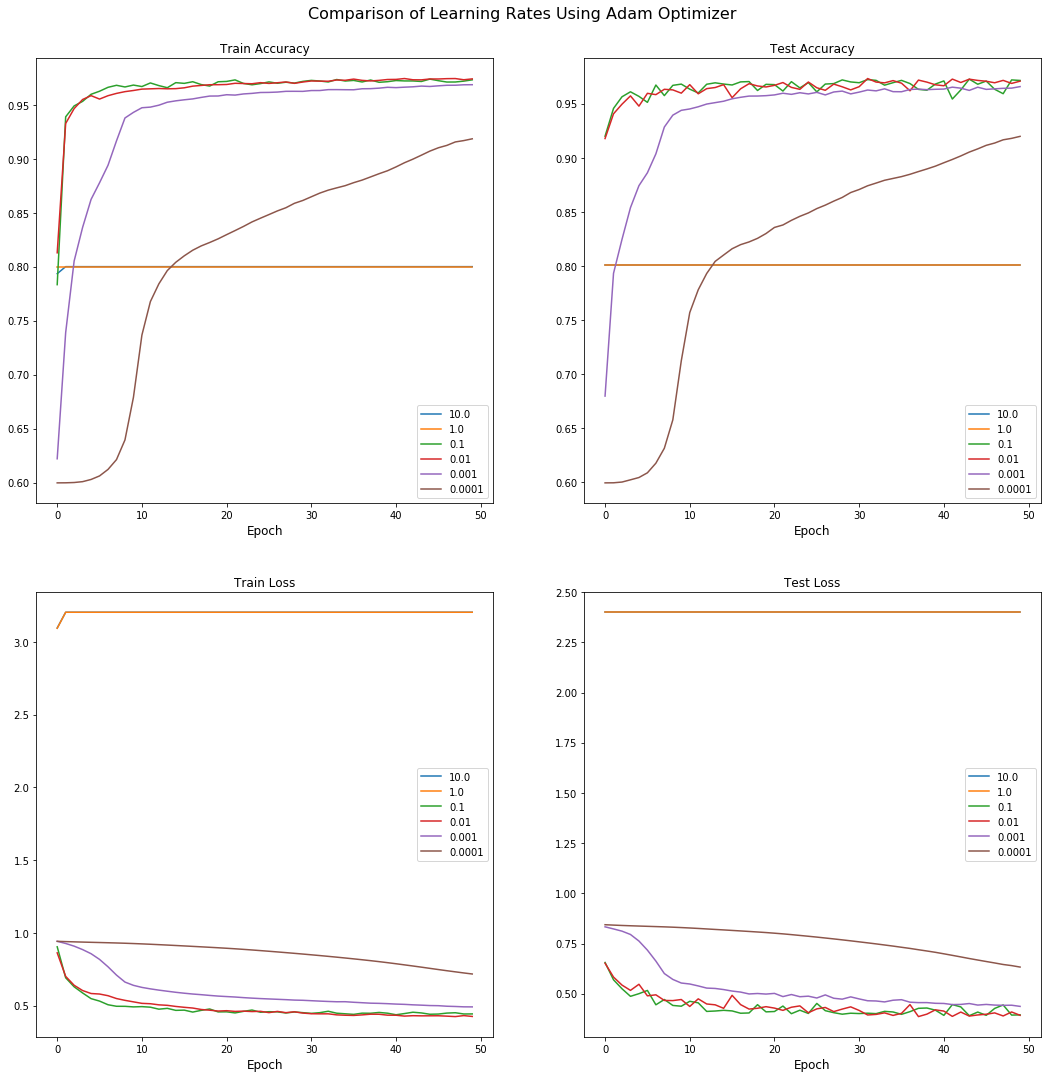

In [22]:
metric = {'Train Accuracy':acc_train, 'Test Accuracy': acc_val, 'Train Loss': loss_train, 'Test Loss': loss_val}

fig, ax = plt.subplots(2,2, figsize=(18,18))
i=0 
j=0
k=0
for m in list(metric.keys()):
    for l in list(acc_train.keys()):
        ax[i,j].plot(metric[m][l], label=str(l))
        ax[i,j].legend(loc='best')
        ax[i,j].set_title(m, fontsize=12)
        ax[i,j].set_xlabel('Epoch', fontsize=12)
        
    if k in [1]: 
        i=i+1
        j=j-1
    else: j=j+1
    k=k+1
    
fig.suptitle('Comparison of Learning Rates Using Adam Optimizer', y=0.92, fontsize=16)

**Answer:**
For `Adam()`, it's hard to tell the difference between $0.1$ and $0.01$. However, $0.01$ does yeild us a slightly better accuracy and less fluctuations in the plot for loss as well as accuracy w.r.t. number of epochs. So we select $0.01$ as our optimal `learning rate` for `Adam()` 

## Q2.2 Optimization with SGD

### Learning Rates

In [23]:
lr_rates = [1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]
acc_train = {}
acc_val = {}
loss_train = {}
loss_val = {}



for l in lr_rates:
    
    model_sgd = build_nn(H=H, L=L, input_dim=input_dim, out_act=out_act, loss=loss, lr=l,
                          momentum=momentum, decay=decay)
    model_sgd_history = model_sgd.fit(X_train, np_utils.to_categorical(y_train),
                                        batch_size=batch_size,
                                        epochs=epochs,verbose=0,
                                        class_weight=class_weights,
                                        validation_data=(X_test, np_utils.to_categorical(y_test)))
    acc_train[l] = np.sqrt(model_sgd_history.history['acc'])
    acc_val[l] = np.sqrt(model_sgd_history.history['val_acc'])
    loss_train[l] = np.sqrt(model_sgd_history.history['loss'])
    loss_val[l] = np.sqrt(model_sgd_history.history['val_loss'])

Text(0.5, 0.92, 'Comparison of Learning Rates Using SGD Optimizer')

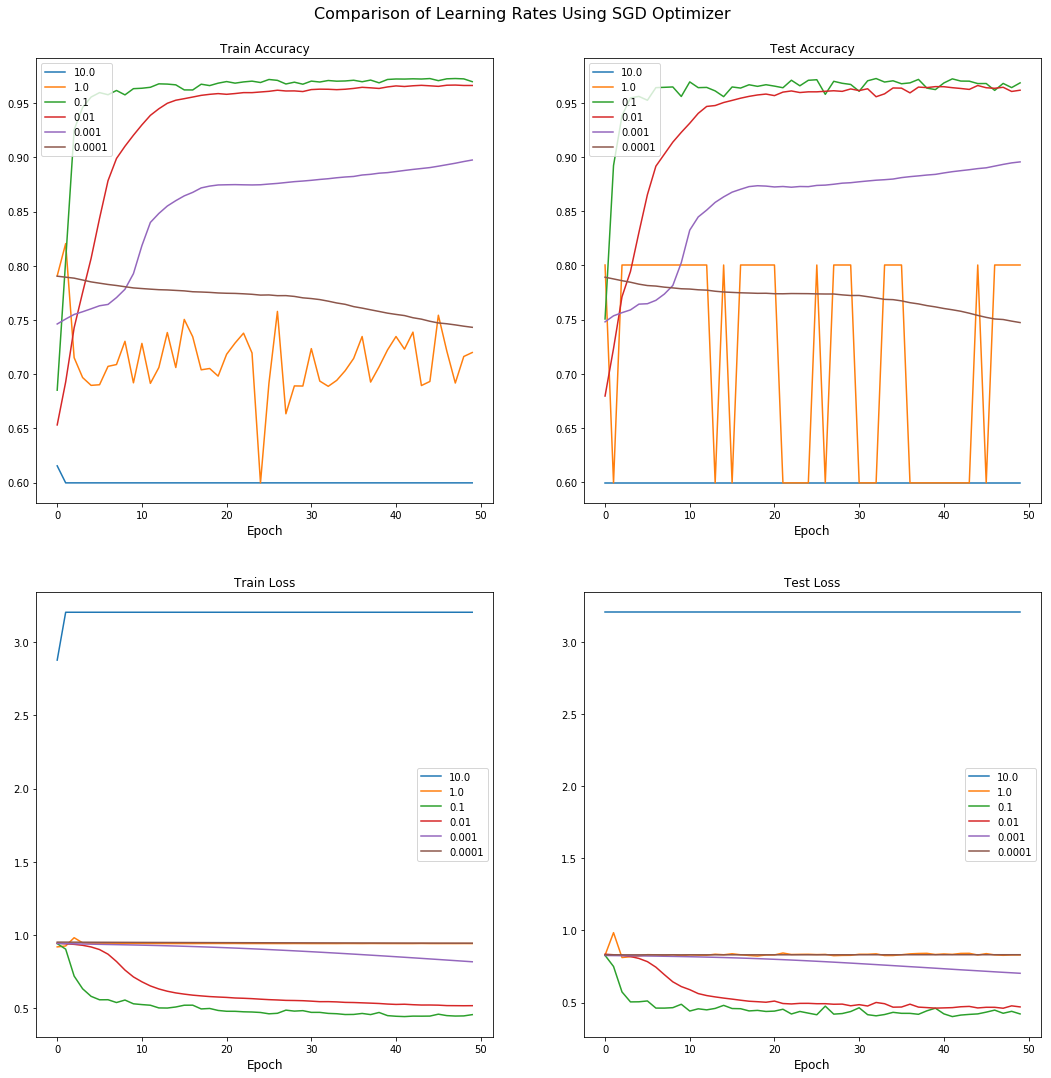

In [24]:
metric = {'Train Accuracy':acc_train, 'Test Accuracy': acc_val, 'Train Loss': loss_train, 'Test Loss': loss_val}

fig, ax = plt.subplots(2,2, figsize=(18,18))
i=0 
j=0
k=0
for m in list(metric.keys()):
    for l in list(acc_train.keys()):
        ax[i,j].plot(metric[m][l], label=str(l))
        ax[i,j].legend(loc='best')
        ax[i,j].set_title(m, fontsize=12)
        ax[i,j].set_xlabel('Epoch', fontsize=12)
        
    if k in [1]: 
        i=i+1
        j=j-1
    else: j=j+1
    k=k+1
fig.suptitle('Comparison of Learning Rates Using SGD Optimizer', y=0.92, fontsize=16)

**Answer:**
Clearly, for `SGD()`, $0.1$ is the best learning rate as it gives the highest accuracy and lowest loss with a fairly smooth plot.

### Momentum

In [25]:
momentum = [9e-1, 8e-1, 7e-1, 6e-1, 5e-1, 4e-1]
lr = 0.1
decay = lr/epochs
acc_train = {}
acc_val = {}
loss_train = {}
loss_val = {}


for mom in momentum:
    
    model_mom = build_nn(H=H, L=L, input_dim=input_dim, out_act=out_act, loss=loss, lr=lr,
                          momentum=mom, decay=decay)
    model_mom_history = model_mom.fit(X_train, np_utils.to_categorical(y_train),
                                                batch_size=batch_size,
                                                epochs=epochs,verbose=0,
                                                class_weight=class_weights,
                                                validation_data=(X_test, np_utils.to_categorical(y_test)))
    
    acc_train[mom] = np.sqrt(model_mom_history.history['acc'])
    acc_val[mom] = np.sqrt(model_mom_history.history['val_acc'])
    loss_train[mom] = np.sqrt(model_mom_history.history['loss'])
    loss_val[mom] = np.sqrt(model_mom_history.history['val_loss'])

Text(0.5, 0.92, 'Comparison of Momentum Using SGD Optimizer')

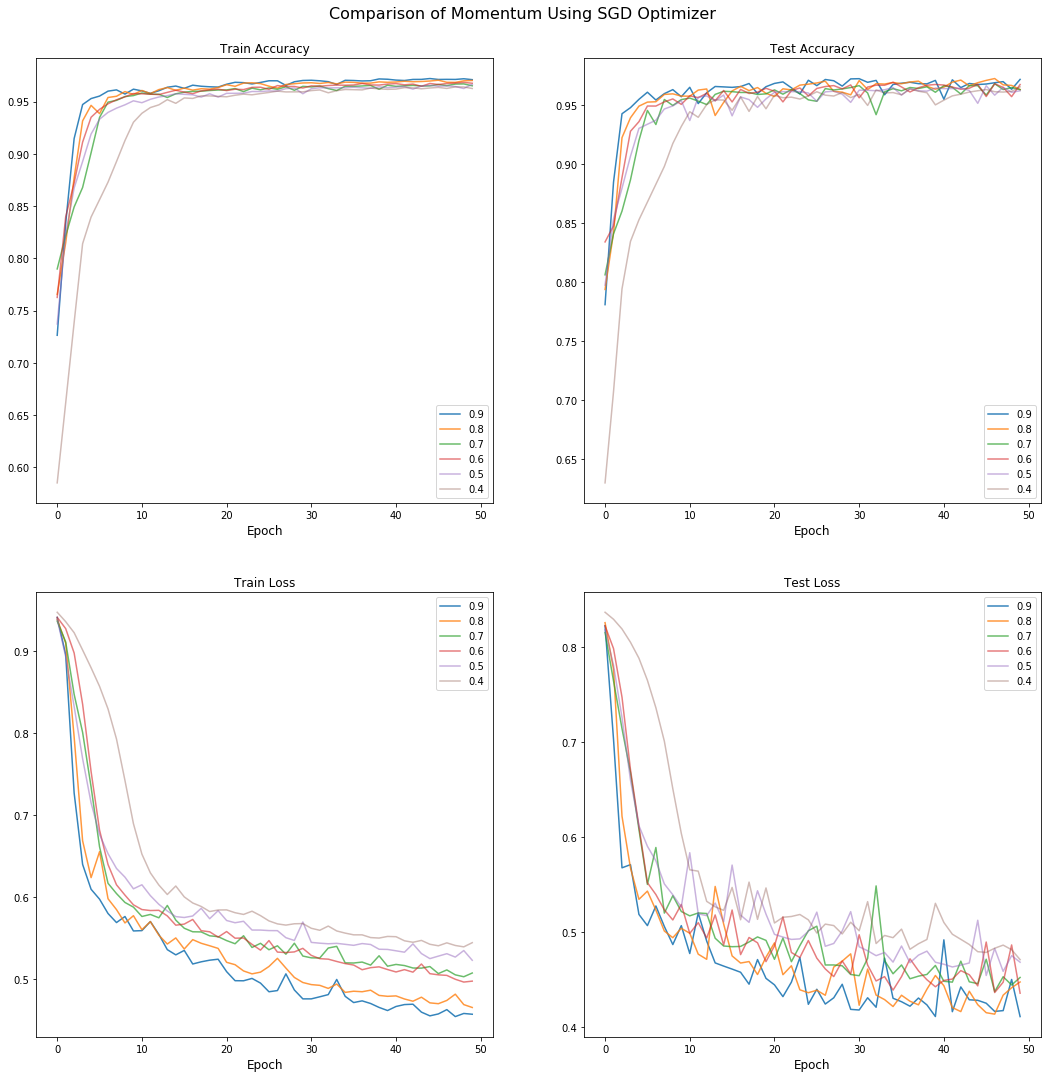

In [26]:
metric = {'Train Accuracy':acc_train, 'Test Accuracy': acc_val, 'Train Loss': loss_train, 'Test Loss': loss_val}

fig, ax = plt.subplots(2,2, figsize=(18,18))
i=0 
j=0
k=0
for m in list(metric.keys()):
    for l in list(acc_train.keys()):
        ax[i,j].plot(metric[m][l], label=str(l), alpha=l)
        ax[i,j].legend(loc='best')
        ax[i,j].set_title(m, fontsize=12)
        ax[i,j].set_xlabel('Epoch', fontsize=12)
        
    if k in [1]: 
        i=i+1
        j=j-1
    else: j=j+1
    k=k+1
fig.suptitle('Comparison of Momentum Using SGD Optimizer', y=0.92, fontsize=16)

**Answer:**
With learning rate held at $0.1$, `SGD()` gives pretty competitive accuracy for $momentum=0.8$ and $0.9$. However, we see that overall, we get a better loss with $momentum=0.9$.

**Note:** We do not perform `Cross-validation`, using an explicit CV algorithm, here as the objective of the `Q2.1` and `Q2.2` is to study the behavior of the model using these different hyperparameters and make an argument for the optimal hyperparameters rather than actually choosing the hyperparameters.

## Q2.3 Model Comparison

**Answer:**

In general, `Adam()` offers a less sporadic loss and accuracy as a function of number of epochs as compared to `SGD()`. This happens because `Adam()` maintains a per parameter learning rate, however, for `SGD()` the same learning rate is used for each parameter.

At the end of 5000 epochs, we'll get a higher accuracy from `SGD()` as `Adam()` will have very small momentum as the number of epochs incerases.

For the purpose of this HW, we think that `Adam()` gives better results with lower learning rates. So when we have sparse gradients, `Adam()` is very helpful in terms of reaching our goal faster.

<div class='exercise'><b> Question 3: Generalizing Models for Galaxy Classification </b></div>

In this problem, you will revisit the task of classifying galaxies based on visual morphology. You will deploy the model you built in Question 1 on a new, much larger sky survey. In this new data set, which for now we will assume it represents the true Universe, only a small number of observations have been labeled. Your goal is to estimate the proportion of elliptical galaxies in the Universe.
<br><br>**Note** There are multiple *correct* answers to these questions. What we are looking for is a scientific approach to support your arguments with empirical evidences or first principles. 

<span class='sub-q'> 3.1 </span> Use the model you built in Question 1 to estimate the proportion of ellipticall galaxies. Is this estimate trust worthy? Why or why not? 

<span class='sub-q'> 3.2 </span> The performance of classifier will perform differently on this new data set than it does on the data the model was trained (and tested on) in question 1. This is a common occurance in machine learning. Identify and eliminate at least one likely cause of this performance difference in the data. 

(***Hint:*** perform some exploratory data analysis on the new data and compare the features distributions of the data set in question 1 and of the data in this question)

<span class='sub-q'> 3.3 (Implementation not required) </span>  Based on your observations, propose a method to produce an accurate estimate of the proportion of elliptical galaxies in the new data set, support your proposal with results from data analysis and concepts from data science. 

In [27]:
universe_df = pd.read_csv('data/galaxy_morphology_semi_labeled.csv')
universe_df.head()

,green_color,red_color,infrared_color,de_vaucouleurs_fit_axial_ratio,exponential_fit_axial_ratio,exponential_disc_fit_log_likelihood,de_vaucouleurs_fit_log_likelihood,star_log_likelihood,number_of_votes,probability_elliptical,probability_spiral,probability_unknown,probability_merger,class
0,20.597660,19.763248,19.377018,0.890790,0.887719,-365.51312,-10296.39500,-69448.500,NaN,NaN,NaN,NaN,NaN,NaN
1,16.068602,14.275770,13.406208,0.846962,0.583541,-12756.09600,-32272.31200,-203823.920,NaN,NaN,NaN,NaN,NaN,NaN
2,25.601834,23.291614,24.511544,0.699872,0.749809,-86.31708,-227.30617,-1036.990,NaN,NaN,NaN,NaN,NaN,NaN
3,22.686954,20.837614,20.032396,0.705292,0.655978,-8858.64400,-1597.61410,-38869.620,NaN,NaN,NaN,NaN,NaN,NaN
4,20.464190,19.271786,18.617180,0.470536,0.424177,-1635.48885,-11248.65150,-83958.805,NaN,NaN,NaN,NaN,NaN,NaN


### Your solutions 

### Pull back training data, testing data, clean/normalize, etc. to re-train original model

In [28]:
# Read in original galaxy data
galaxy_df = pd.read_csv('data/galaxy_morphology_labeled.csv')
galaxy_df.head()

# Cefine binary classification for full dataset
galaxy_df["binary_class"] = galaxy_df["class"].apply(lambda x: 1 if x == "elliptical" else 0)

# Split source data into train/test
train, test = train_test_split(galaxy_df, test_size=.3, random_state=42)

# Create lb and ub to filter extreme values (+/- std*2.5)
lb, ub = (train["green_color"].mean()-2.5*train["green_color"].std(),
          train["green_color"].mean()+2.5*train["green_color"].std())

# Keep only rows within range
train = train.loc[(train["green_color"] > lb) &
                  (train["green_color"] < ub),]
test = test.loc[(test["green_color"] > lb) &
                (test["green_color"] < ub),]

# Specify features on which to classify (excluding label related columns)
orig_features = [col for col in train.columns \
                 if col not in ["number_of_votes",
                                "probability_elliptical",
                                "probability_spiral",
                                "probability_unknown",
                                "probability_merger",
                                "class", 
                                "binary_class"]]      

# Engineer new feature for green-red
# Engineer new feature for red-infrared
# Perform same engineering to test as train
train["g_r_diff"] = train["green_color"]-train["red_color"]
train["r_i_diff"] = train["red_color"]-train["infrared_color"]
test["g_r_diff"] = test["green_color"]-test["red_color"]
test["r_i_diff"] = test["red_color"]-test["infrared_color"]

# Define engineered feature list
eng_features = ["g_r_diff", "r_i_diff"]

# Define x & y for train and test
x_train = train[orig_features+eng_features]
y_train = train["binary_class"]
x_test = test[orig_features+eng_features]
y_test = test["binary_class"]

# Convert x into scaled numpy array (using same Scaler on test as on train)
scaler = StandardScaler().fit(x_train.astype(np.float64))
x_train_scaled = scaler.transform(x_train.astype(np.float64))
x_test_scaled = scaler.transform(x_test.astype(np.float64))

# Convert y into categorial for Keras
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

# Define ratio of of non-ellip to ellip
# Use this ratio to give more weight in loss function
# to the underweighted (elliptical) class
count_elliptical = train[train["binary_class"]==1].green_color.count()
count_non_elliptical = train[train["binary_class"]==0].green_color.count()
re_weight_ratio = count_non_elliptical / count_elliptical

# Create sample_weight array to tell loss function to give more penalty for ellipticals
sample_weight = train["binary_class"].apply(lambda x: 1 if x == 0 else re_weight_ratio).values

### Re-train original model on original galaxy data just to be complete

In [29]:
# Define fixed hyperparameters
batch_size = 1024
epochs=50
learning_rate = 0.01
decay = 0.005

# Build the model
input_dim = x_train_scaled.shape[1]

model = Sequential()
model.add(Dense(40, activation="relu", input_dim = input_dim))
model.add(Dense(30, activation="relu"))
model.add(Dense(25, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(15, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(5, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=2, activation="sigmoid"))
print(model.summary())

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=learning_rate,
                                        beta_1=.9,
                                        beta_2=.999,
                                        decay=decay,
                                        amsgrad=False),
              metrics=["accuracy"])

# Set callbacks to early stop and save best model
callbacks = [EarlyStopping(monitor="val_loss", patience=4),
             ModelCheckpoint(filepath="best_model", 
                             monitor="val_loss", 
                             save_best_only=True)]

# Fit the model with sample weightings
model_history = model.fit(x_train_scaled, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=0,
                          sample_weight=sample_weight,
                          validation_data=(x_test_scaled, y_test))

# Just for completeness, print final scores and calculate r2
score = model.evaluate(x_test_scaled, y_test, verbose=0)
print(f"Test Loss = {score[0]}.")
print(f"Test Accuracy = {score[1]}.")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_121 (Dense)            (None, 40)                440       
_________________________________________________________________
dense_122 (Dense)            (None, 30)                1230      
_________________________________________________________________
dense_123 (Dense)            (None, 25)                775       
_________________________________________________________________
dense_124 (Dense)            (None, 20)                520       
_________________________________________________________________
dense_125 (Dense)            (None, 15)                315       
_________________________________________________________________
dense_126 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_127 (Dense)            (None, 5)                 55        
__________

In [30]:
# Print portion of test data that is elliptical
n_test_e = test[test["binary_class"]==1].green_color.count()
n_test_non_e = test[test["binary_class"]==0].green_color.count()
print(f"% Ellip in Galaxy Test= {(n_test_e/(n_test_non_e+n_test_e)):3.2}")

% Ellip in Galaxy Test= 0.37


In [31]:
# Create predictions from galaxy test data
predictions = model.predict(x_test_scaled)
predictions_df = pd.DataFrame(predictions, columns = ["prob_0", "prob_1"])
predictions_df["Elliptical"] = predictions_df["prob_1"].apply(lambda x: 1 if x > .5 else 0)

# Print portion of test data predicted to be elliptical
n_predict_e = predictions_df[predictions_df["Elliptical"]==1].Elliptical.count()
n_predict_non_e = predictions_df[predictions_df["Elliptical"]==0].Elliptical.count()
print(f"% Ellip Predicted in Galaxy Test= {(n_predict_e/(n_predict_e+n_predict_non_e)):3.2}")

% Ellip Predicted in Galaxy Test= 0.36


## Q3.1:  NOW RE-USE TRAINED MODEL WITH NEW UNIVERSE DATA

In [32]:
universe_df = pd.read_csv('data/galaxy_morphology_semi_labeled.csv')
universe_df.head()

,green_color,red_color,infrared_color,de_vaucouleurs_fit_axial_ratio,exponential_fit_axial_ratio,exponential_disc_fit_log_likelihood,de_vaucouleurs_fit_log_likelihood,star_log_likelihood,number_of_votes,probability_elliptical,probability_spiral,probability_unknown,probability_merger,class
0,20.597660,19.763248,19.377018,0.890790,0.887719,-365.51312,-10296.39500,-69448.500,NaN,NaN,NaN,NaN,NaN,NaN
1,16.068602,14.275770,13.406208,0.846962,0.583541,-12756.09600,-32272.31200,-203823.920,NaN,NaN,NaN,NaN,NaN,NaN
2,25.601834,23.291614,24.511544,0.699872,0.749809,-86.31708,-227.30617,-1036.990,NaN,NaN,NaN,NaN,NaN,NaN
3,22.686954,20.837614,20.032396,0.705292,0.655978,-8858.64400,-1597.61410,-38869.620,NaN,NaN,NaN,NaN,NaN,NaN
4,20.464190,19.271786,18.617180,0.470536,0.424177,-1635.48885,-11248.65150,-83958.805,NaN,NaN,NaN,NaN,NaN,NaN


### Drop NA from universe data

In [33]:
# Check for na values
r0 = universe_df.shape[0]
r1 = universe_df.dropna().shape[0]
print(f"universe_df appears to have {r0-r1} rows with NA values in a column.")

universe_df appears to have 42317 rows with NA values in a column.


### Enhance universe data with extra engineered columns

In [34]:
# Engineer new feature for green-red
# Engineer new feature for green-infrared
universe_df["g_r_diff"] = universe_df["green_color"]-universe_df["red_color"]
universe_df["r_i_diff"] = universe_df["red_color"]-universe_df["infrared_color"]

### Scale universe data using standard scaler FROM TRAINING

In [35]:
# Create DF with just features
x_universe = universe_df[orig_features+eng_features] 

# Convert x into scaled numpy array using original scaler from training
x_universe_scaled = scaler.transform(x_universe.astype(np.float64))

### Use pre-trained model with new universe data to predict

In [36]:
# Create predictions from new universe data using model trained on galaxy data
predictions = model.predict(x_universe_scaled)
predictions_df = pd.DataFrame(predictions, columns = ["prob_0", "prob_1"])
predictions_df["Elliptical"] = predictions_df["prob_1"].apply(lambda x: 1 if x > .5 else 0)

# Print portion of universe data predicted to be elliptical
n_predict_e = predictions_df[predictions_df["Elliptical"]==1].Elliptical.count()
n_predict_non_e = predictions_df[predictions_df["Elliptical"]==0].Elliptical.count()
print(f"% Ellip Predicted in Universe= {(n_predict_e/(n_predict_e+n_predict_non_e)):3.2}")

% Ellip Predicted in Universe= 0.98


### Comparing Distribution of Features Data in Galaxy and Universe

/usr/share/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


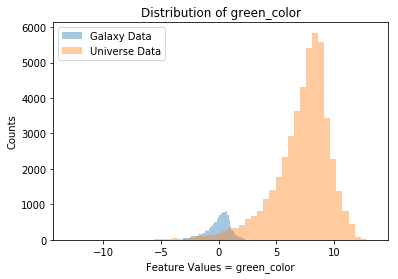

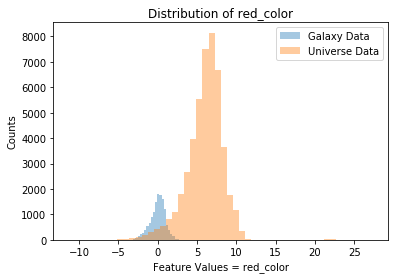

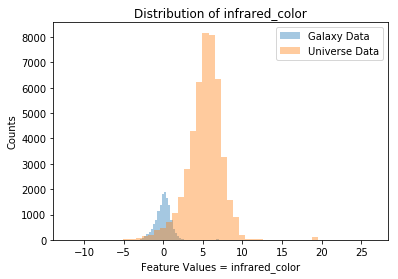

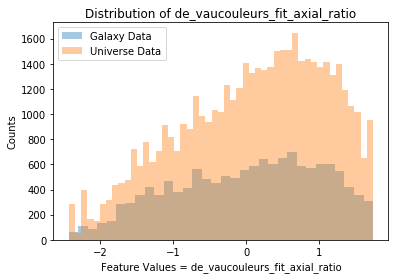

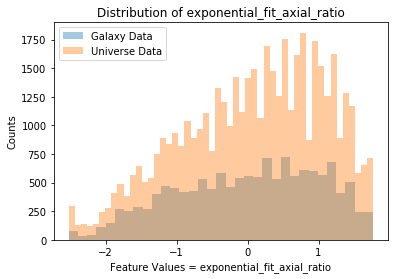

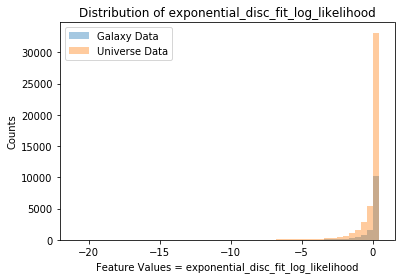

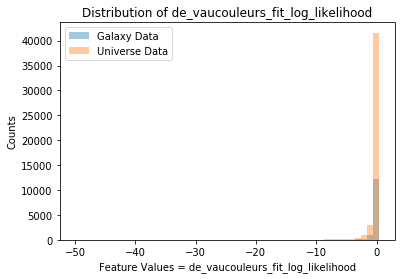

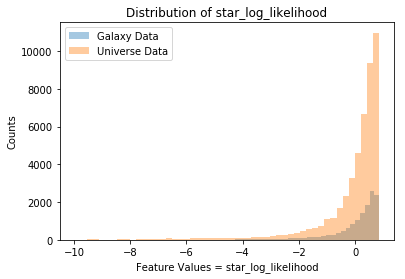

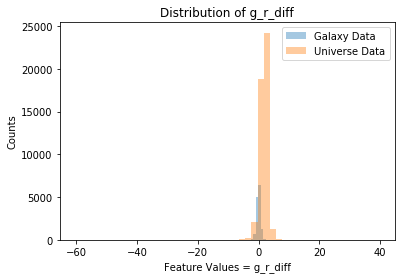

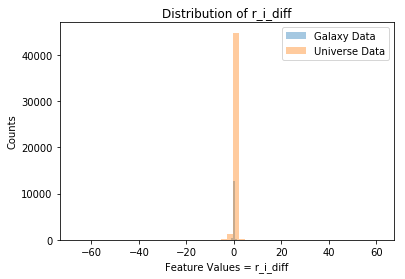

In [37]:
# Show distribution of values for each feature galaxy vs. universe
for i, feature in enumerate(orig_features+eng_features):
    xg = x_train_scaled[:,i]
    xu = x_universe_scaled[:,i]
    
    # Plot histogram
    fig, ax = plt.subplots()
    sns.distplot(xg, label = "Galaxy Data", kde=False, ax=ax)
    sns.distplot(xu, label = "Universe Data", kde=False, ax=ax)
    plt.xlabel(f"Feature Values = {feature}")
    plt.ylabel("Counts")
    plt.title(f"Distribution of {feature}")
    plt.legend()

**STUDENT COMMENTARY:**

- The percentage of ellipticals in the universe (as predicted by the model trained on galaxy data) is very high (e..g, 99%) while the galaxy test data and predictions showed around .37.
- While it is possible the galaxy data happens to have a small percentage of ellipticals while the universe is almost all ellipticals, there is probably another reason for the universe predictions leading to so many ellipticals:  
    - **As the diagrams show above**, the universe data (even after being scaled with the same scaler used for training and test data in the galaxy modeling) has features with data with very different means and standard deviations.
    - Predicting with the galaxy trained model uses weightings that learned from training data that "looks" very different from the new universe data.  This makes the model's predictive abilities dubious.


## Q3.2:  MAKE 1 CORRECTION TO IMPROVE PERFORMANCE

### Eliminate data with red_color/green_color in universe data more 2.5 sd beyond mean of galaxy data

In [38]:
# Make small_universe as copy of full universe before we start dropping rows
small_universe_df = universe_df

# Drop universe data with color feature values 2.5 std from mean of galaxy values
for feature in ["red_color", "green_color"]:
    lb, ub = (train[feature].mean()-2.5*train[feature].std(),
              train[feature].mean()+2.5*train[feature].std())
    
    
    # Keep only rows within range
    small_universe_df = small_universe_df.loc[(small_universe_df[feature] > lb) &
                                              (small_universe_df[feature] < ub),]

# Create DF with just features
x_small_universe = small_universe_df[orig_features+eng_features] 

# Convert x into scaled numpy array using original scaler from training
x_small_universe_scaled = scaler.transform(x_small_universe.astype(np.float64))

### Comparing Distribution of Features Data in Galaxy and Universe (after dropping rows)

/usr/share/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


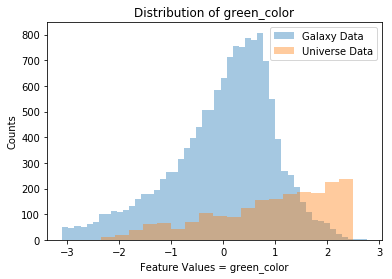

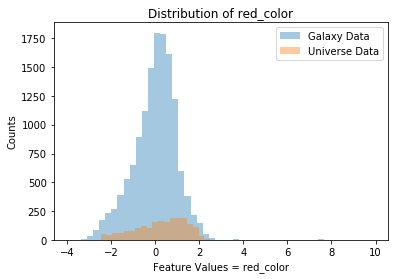

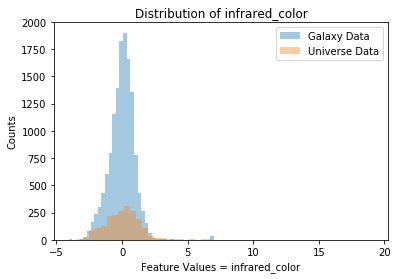

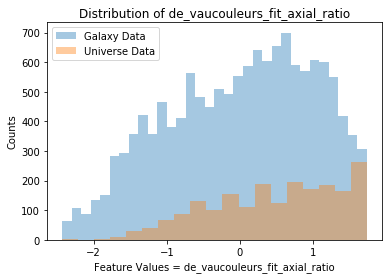

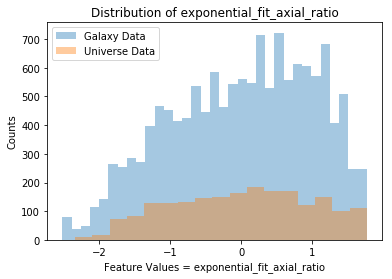

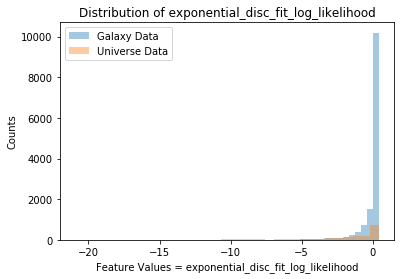

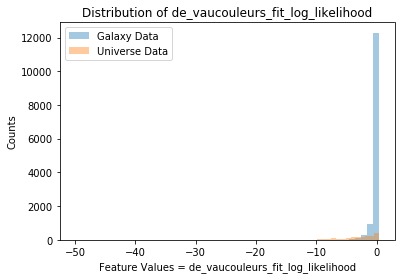

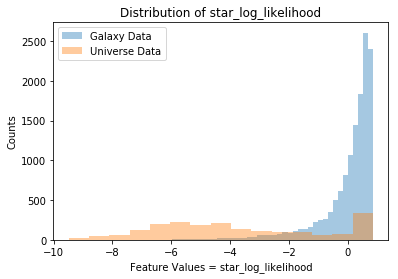

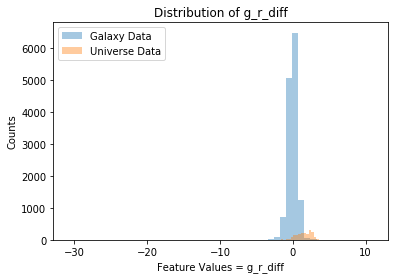

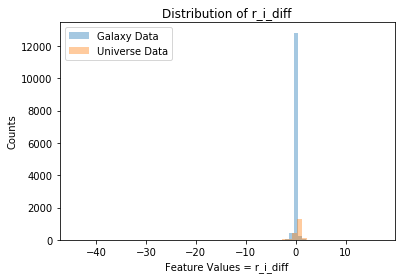

In [39]:
# Show distribution of values for each feature galaxy vs. universe
for i, feature in enumerate(orig_features+eng_features):
    
    xg = x_train_scaled[:,i]
    xu = x_small_universe_scaled[:,i]
    
    # Plot histogram
    fig, ax = plt.subplots()
    sns.distplot(xg, label = "Galaxy Data", kde=False, ax=ax)
    sns.distplot(xu, label = "Universe Data", kde=False, ax=ax)
    plt.xlabel(f"Feature Values = {feature}")
    plt.ylabel("Counts")
    plt.title(f"Distribution of {feature}")
    plt.legend()

### Predict again

In [40]:
# Create predictions from new universe data using model trained on galaxy data
predictions = model.predict(x_small_universe_scaled)
predictions_df = pd.DataFrame(predictions, columns = ["prob_0", "prob_1"])
predictions_df["Elliptical"] = predictions_df["prob_1"].apply(lambda x: 1 if x > .5 else 0)

# Print portion of universe data predicted to be elliptical
n_predict_e = predictions_df[predictions_df["Elliptical"]==1].Elliptical.count()
n_predict_non_e = predictions_df[predictions_df["Elliptical"]==0].Elliptical.count()
print(f"% Ellip Predicted in (small) Universe= {(n_predict_e/(n_predict_e+n_predict_non_e)):3.2}")

% Ellip Predicted in (small) Universe= 0.85


**STUDENT COMMENTARY:**

- In the above cells, we eliminate observations from the universe where the red or green color values for the universe are more than 2.5 sd beyond the mean of the galaxy data.
- This adjustment to the universe data has brought the percentage of ellipticals predicted in the unverse down.  But, it also dropped a large number of observations for which feature values differed the most with feature values in our galaxy training data.

## Q3.3:  OTHER PROPOSALS

### Look at distribution of feature values for labeled universe data vs. full universe vs. galaxy

In [41]:
# Look at only labeled rows in universe by dropping labels=NaN
universe_labeled=universe_df.dropna()

# Create DF with just features
x_universe_labeled = universe_labeled[orig_features+eng_features] 

# Convert x into scaled numpy array using original scaler from training
x_universe_labeled_scaled = scaler.transform(x_universe_labeled.astype(np.float64))

/usr/share/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


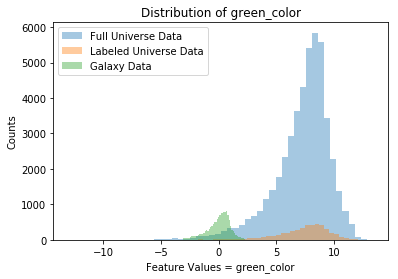

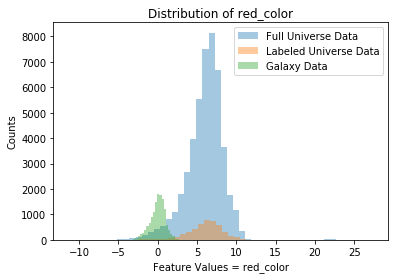

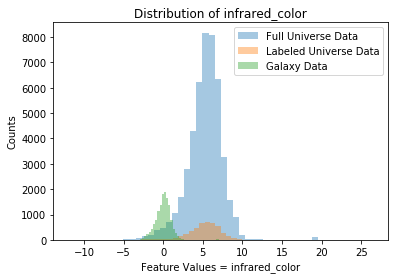

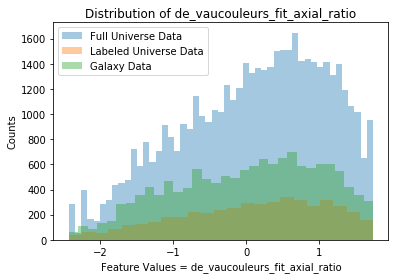

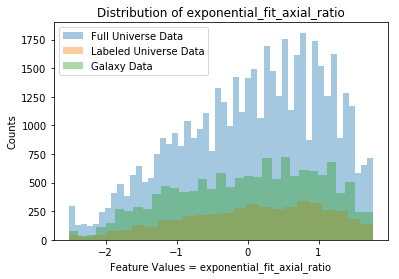

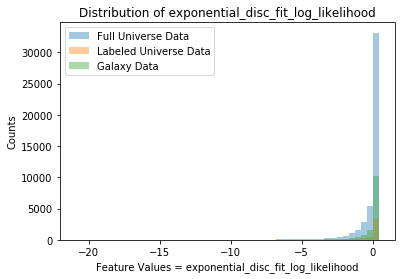

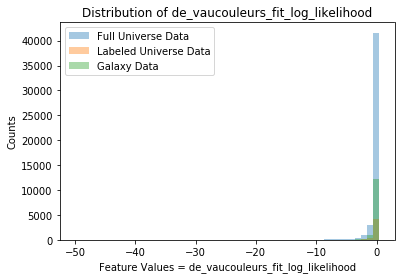

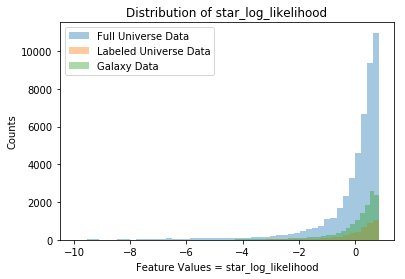

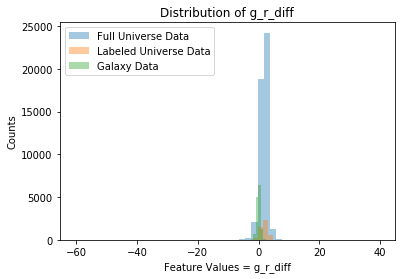

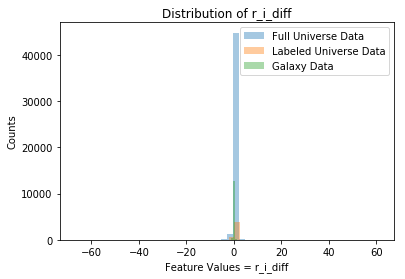

In [42]:
# Show distribution of values for each feature labeled universe vs. total universe
for i, feature in enumerate(orig_features+eng_features):
    
    xu = x_universe_scaled[:,i]
    xul = x_universe_labeled_scaled[:,i]
    xg = x_train_scaled[:,i]
    
    # Plot histogram
    fig, ax = plt.subplots()
    sns.distplot(xu, label = "Full Universe Data", kde=False, ax=ax)
    sns.distplot(xul, label = "Labeled Universe Data", kde=False, ax=ax)
    sns.distplot(xg, label = "Galaxy Data", kde=False, ax=ax)
    plt.xlabel(f"Feature Values = {feature}")
    plt.ylabel("Counts")
    plt.title(f"Distribution of {feature}")
    plt.legend()

**STUDENT COMMENTARY:**

The root of the problem is that the data for the universe has feature values that differ meaningfully in both mean and variance from the feature values of the galaxy upon which we trained.  To the extent there is a relationship between the feature values and the classification labels, our model does not know what that relationship is.  We can simply make predictions for the narrow set of observations with universe feature values in the range of our training data (see Q3.2 above), but this is overly narrowing our problem.

One solution would be to collect training data from the universe and train a new model using this new training data.  The universe data we were given did have some observations with labels, so perhaps this "training on universe data" is posible.  The labeled universe training data would have to have feature values distributed in a manner similar to the universe. The analysis above of the distribution of feature values for the labeled universe vs. the full universe shows significant differences is variance (though similarity in mean).   So, the idea of using labeled universe data as training data for a new model is not promising.

Perhaps a better solution involves the following ideas, but it is hard to fully articulate:

- The charts above do show the labeled universe data has a mean similar to the mean for the full universe.

- The charts above do show the range of feature values for the full universe is closely approximated by the combination of ranges for the labeled galaxy data and the labeled universe data.

- Perhaps the 209b lecture on **Optimal Transport** would allow us to "transport" and transform the labeled data from the galaxy dataset **into** the universe dataset.  With both the labeled galaxy data (transported into universe) and the labeled universe data, we could then train a universe model